In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as pl
import scipy.stats as stats
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.model_selection import train_test_split
from datetime import datetime
from sklearn.metrics import accuracy_score


In [2]:
df = pd.read_csv('sap_storing_data_hu_project.csv')

C:\Users\emiel\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (0,11,19,21,24,25,27,32,33,36,37,38,39,40,46,47,48,49,51,53,55,56,60,73,75,78,80,82,83,86,87,91,95,99,102,103,104,107,108,109,110,111,112,113,116,118,119,120,121,122,123,124,129) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
def column_outlier(strength, dataframe, columns):
    temp_dataframe = dataframe.copy()
    try:
        if strength == 's':
            strength=3
        elif strength == 'a':
            strength=1.5
    except:
        print("Invalid strength")
    for column in columns:
        Q1 = temp_dataframe[column].quantile(0.25)
        Q3 = temp_dataframe[column].quantile(0.75)
        IQR = Q3 - Q1
        temp_dataframe = temp_dataframe[~((temp_dataframe[column] < (Q1 - strength * IQR)) |(temp_dataframe[column] > (Q3 + strength* IQR)))]
    return temp_dataframe

In [4]:
def get_accuracy(r,zip_list):

    return len([ _ for x in zip_list if x[0]+r >= x[1] >= x[0]-r])/len(zip_list)

<h2>Data Cleaning </h2>

In [5]:
# ik zorg er hier voor dat de 'stm_progfh_in_duur' kolom naar floats gecast wordt
df.stm_progfh_in_duur = df.stm_progfh_in_duur.apply(lambda x: float(str(x).replace('-','').replace('*','').strip()))

# delete stm_fh_duur outliers
#df = column_outlier('a', df.copy(), ['stm_fh_duur'])


# voeg dummy kolommen voor seizoenen toe
df.stm_sap_melddatum = pd.to_datetime(df.stm_sap_melddatum)

df['date_offset'] = (df.stm_sap_melddatum.dt.month*100 + df.stm_sap_melddatum.dt.day - 320)%1300

df['seizoen_melding'] = pd.cut(df['date_offset'], [0, 300, 602, 900, 1300], 
                      labels=['spring', 'summer', 'autumn', 'winter'])

df.drop(['date_offset'], axis=1)
df = df.join(pd.get_dummies(df.seizoen_melding))

# join de oorzaakcodes
o_df = pd.read_csv('Oorzaakcodes.csv', sep = ';')
o_df = o_df.rename(columns={'Code': 'stm_oorz_code'})
df = df.merge(o_df, on = 'stm_oorz_code', how = 'outer')

In [6]:
pd.set_option('display.max_rows', None)

In [7]:
pd.set_option('display.max_columns', None)

In [8]:
df.drop(df[df.stm_fh_duur == 0].index, inplace=True)

In [9]:
new_df_copy = column_outlier('a', df.copy(), ['stm_fh_duur'])

<AxesSubplot:xlabel='stm_fh_duur', ylabel='Density'>

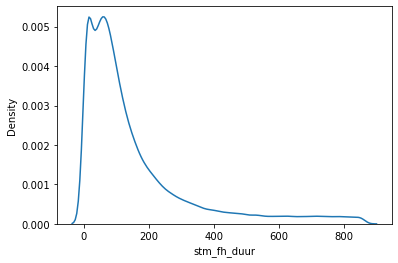

In [10]:
sns.kdeplot(new_df_copy.stm_fh_duur)

In [11]:
# hoe groot de bins worden die de 'stm_fh_duur' kolom verdelen
error_margin = 10

<h2> MODEL COMPARISON </h2>

In [12]:
df_co = column_outlier('a', df.copy(), ['stm_fh_duur'])
#df_co = df_co[df_co.Oorzaak == 'IJsafzetting/ijzel']

In [13]:
bins = [x for x in range(0,900,error_margin)]
labels = [x for x in range(1,len(bins))]

df_co['duration_bin'] = pd.cut(df_co['stm_fh_duur'], bins = bins, labels=labels)

In [14]:
df_co = df_co[['Oorzaak','stm_equipm_nr_mld', 'stm_prioriteit', 'stm_km_tot_mld', 'stm_km_van_mld','stm_fh_duur', 'stm_progfh_in_duur','duration_bin', 'stm_rapportage_jaar','spring', 'summer','autumn','winter']].sample(frac = 1).dropna()


In [15]:
# svm, random forests en gaussion process classifier duren veels te lang op deze dataset
X = df_co[['stm_equipm_nr_mld', 'stm_prioriteit', 'stm_km_tot_mld', 'stm_km_van_mld', 'stm_rapportage_jaar','spring', 'summer','autumn','winter']]
y = df_co.duration_bin
X = X.join(pd.get_dummies(df.stm_oorz_code)).dropna()
X = X.join(pd.get_dummies(df.stm_equipm_soort_mld)).dropna()


X_train_dt, X_test_dt, y_train_dt, y_test_dt = train_test_split(X, y, test_size=0.2)

clf = DecisionTreeClassifier(random_state=0).fit(X_train_dt, y_train_dt)

y_pred_dt = clf.predict(X_test_dt)

accuracy_score(y_test_dt,y_pred_dt)

0.47571854321361823

In [16]:
X = df_co[['stm_equipm_nr_mld', 'stm_prioriteit', 'stm_km_tot_mld', 'stm_rapportage_jaar','spring', 'summer','autumn','winter']]
y = df_co.duration_bin

X_train_kn, X_test_kn, y_train_kn, y_test_kn = train_test_split(X, y, test_size=0.2)

clf2 = KNeighborsClassifier(n_neighbors = 1).fit(X_train_kn, y_train_kn)

y_pred_kn = clf2.predict(X_test_kn)
accuracy_score(y_test_kn,y_pred_kn)

0.45192705965550334

In [17]:
my_df = df.select_dtypes(include=np.number)
# drop columns with > 100.000 NaNs
my_df = my_df.drop(columns = ['stm_equipm_nr_mld', 'stm_mon_nr__statuscode', 'stm_geo_gst_uit_functiepl', 'stm_equipm_nr_gst', 'stm_contractgeb_mld', 'stm_progfh_gw_lwd_datum', 'stm_status_sapnaarmon', 'stm_schadenr'])
my_df = my_df.join(df_co['duration_bin'])


my_df = column_outlier('a', my_df.copy(), ['stm_arbeid', 'stm_reactie_duur'])

my_df = my_df.dropna()


X = my_df.drop(columns = ['duration_bin', 'stm_fh_duur', 'stm_mon_nr', 'stm_geo_mld_uit_functiepl', '#stm_sap_meldnr', 'stm_oorz_code', 'stm_fh_status', 'stm_tao_telling_mutatie', 'stm_progfh_in_duur', 'stm_progfh_gw_teller', 'stm_rapportage_maand', 'stm_rapportage_jaar', 'stm_x_actueel_ind', 'stm_x_run_id', 'stm_x_bk', 'stm_x_vervallen_ind', 'date_offset', 'stm_arbeid'])
y = my_df.duration_bin


X_train_dt2, X_test_dt2, y_train_dt2, y_test_dt2 = train_test_split(X, y, test_size=0.2)
clf3 = DecisionTreeClassifier(random_state = 0).fit(X_train_dt2, y_train_dt2)
y_pred_dt2 = clf3.predict(X_test_dt2)
accuracy_score(y_test_dt2, y_pred_dt2)

0.5225046284376111

In [18]:
cause_df = df_co[['Oorzaak', 'stm_fh_duur']].groupby('Oorzaak', as_index = False ).mean()

In [19]:
bins = [x for x in range(0,900,error_margin)]
labels = [x for x in range(1,len(bins))]

cause_df['duration_bin'] = pd.cut(cause_df['stm_fh_duur'], bins = bins, labels=labels)

In [20]:
def cause_predict(causes, cause_df):
    """model that returns the expected duration bin of a specific cause"""
    
    valid_causes = list(cause_df.Oorzaak)
    
    cause_dic = {v : float(cause_df[cause_df.Oorzaak == v].duration_bin) for v in valid_causes }
    
    return [cause_dic[c] for c in causes]

In [21]:
bins = [x for x in range(0,900,error_margin)]
labels = [x for x in range(1,len(bins))]
prog_df = df_co.copy()[['stm_progfh_in_duur','duration_bin']]
prog_df = column_outlier('a', prog_df.copy(), ['stm_progfh_in_duur'])
prog_df['prog_duration_bin'] = pd.cut(prog_df['stm_progfh_in_duur'], bins = bins, labels=labels)
prog_df = prog_df.dropna()
prog_df = prog_df[['duration_bin', 'prog_duration_bin']]

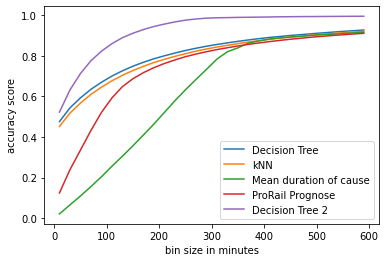

In [22]:
x_ax = [error_margin +(20*x) for x in range(0,30)]

y1_ax = [get_accuracy(x, list(zip(list(y_test_dt), y_pred_dt))) for x in range(0,30)]
y2_ax = [get_accuracy(x, list(zip(list(y_test_kn), y_pred_kn))) for x in range(0,30)]


X = df_co['Oorzaak']
y = df_co['duration_bin']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

y3_ax = [get_accuracy(x, list(zip(list(y_test), cause_predict(list(X_train), cause_df)))) for x in range(0,30)]


y4_ax = [get_accuracy(x, list(zip(list(prog_df.duration_bin), list(prog_df.prog_duration_bin)))) for x in range(0,30)]

y5_ax = [get_accuracy(x, list(zip(list(y_test_dt2), y_pred_dt2))) for x in range(0,30)]


plt.plot(x_ax,y1_ax, label = 'Decision Tree')
plt.plot(x_ax,y2_ax, label = 'kNN')
plt.plot(x_ax,y3_ax, label = 'Mean duration of cause')
plt.plot(x_ax,y4_ax, label = 'ProRail Prognose')
plt.plot(x_ax,y5_ax, label = 'Decision Tree 2')



plt.xlabel('bin size in minutes')
plt.ylabel('accuracy score')

plt.legend()
plt.show()

In [23]:
# chance to predict the right bin, decision tree
y1_ax[0]

0.47571854321361823

In [24]:
# chance to predict the right bin, KNN
y2_ax[0]

0.45192705965550334

In [25]:
# chance to predict the right bin, cause predict
y3_ax[0]

0.02136687376875284

In [26]:
# chance to predict the right bin, ProRail prognose
y4_ax[0]

0.12449492808906219

In [27]:
# chance to predict the right bin, decision tree 2
y5_ax[0]

0.5225046284376111

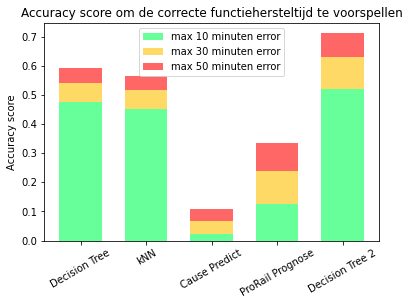

In [28]:
labels = ['Decision Tree', 'kNN', 'Cause Predict', 'ProRail Prognose', 'Decision Tree 2']

min_10 = [eval(f"y{i}_ax[0]") for i in range(1,len(labels)+1)]
min_30 = [eval(f"y{i}_ax[1]") - eval(f"y{i}_ax[0]") for i in range(1,len(labels)+1)]
min_50 = [eval(f"y{i}_ax[2]") - eval(f"y{i}_ax[1]") for i in range(1,len(labels)+1)]

width = 0.65       

fig, ax = plt.subplots()

ax.bar(labels, min_10, width, label='max 10 minuten error', color = '#66ff99')
ax.bar(labels, min_30, width ,bottom=min_10,label='max 30 minuten error', color = '#ffd966')
ax.bar(labels, min_50, width ,bottom=(np.array(min_30) + np.array(min_10)),label='max 50 minuten error', color = '#ff6666')


ax.set_ylabel('Accuracy score')
ax.set_title('Accuracy score om de correcte functiehersteltijd te voorspellen')
ax.legend()

plt.xticks(rotation=30)


plt.show()

In [33]:
list(X_train_dt2.columns)

['stm_km_van_mld',
 'stm_km_tot_mld',
 'stm_prioriteit',
 'stm_km_van_gst',
 'stm_km_tot_gst',
 'stm_contractgeb_gst',
 'stm_reactie_duur',
 'spring',
 'summer',
 'autumn',
 'winter']

In [32]:
list(X_train_dt.columns)

['stm_equipm_nr_mld',
 'stm_prioriteit',
 'stm_km_tot_mld',
 'stm_km_van_mld',
 'stm_rapportage_jaar',
 'spring',
 'summer',
 'autumn',
 'winter',
 33.0,
 48.0,
 51.0,
 130.0,
 131.0,
 132.0,
 133.0,
 134.0,
 135.0,
 136.0,
 139.0,
 140.0,
 141.0,
 142.0,
 143.0,
 144.0,
 145.0,
 146.0,
 147.0,
 148.0,
 149.0,
 150.0,
 151.0,
 152.0,
 153.0,
 154.0,
 180.0,
 181.0,
 182.0,
 183.0,
 184.0,
 185.0,
 186.0,
 187.0,
 188.0,
 189.0,
 200.0,
 201.0,
 202.0,
 203.0,
 204.0,
 205.0,
 206.0,
 207.0,
 208.0,
 209.0,
 210.0,
 211.0,
 212.0,
 213.0,
 214.0,
 215.0,
 218.0,
 219.0,
 220.0,
 221.0,
 222.0,
 223.0,
 224.0,
 225.0,
 226.0,
 227.0,
 228.0,
 229.0,
 230.0,
 231.0,
 233.0,
 234.0,
 235.0,
 239.0,
 240.0,
 241.0,
 242.0,
 250.0,
 294.0,
 298.0,
 299.0,
 999.0,
 '25AARDELEC',
 '25AARDVERB',
 '25AFNAMEPT',
 '25AFSPANN',
 '25AUTOTRAF',
 '25BESCHAAR',
 '25BEVEILHS',
 '25BEWARM',
 '25BOVNLEID',
 '25BVLSCHAK',
 '25CNTBDRVR',
 '25C_BANK',
 '25DRGCIE',
 '25DRGCIEBV',
 '25DRGKABEL',
 '25ELVERB',
 

In [34]:
list(X_train_kn.columns)

['stm_equipm_nr_mld',
 'stm_prioriteit',
 'stm_km_tot_mld',
 'stm_rapportage_jaar',
 'spring',
 'summer',
 'autumn',
 'winter']